In [1]:

%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_groq langchain_community

In [2]:

import os, getpass

def _set_env(var: str, value: str):
    os.environ[var] = value

_set_env("GROQ_API_KEY", "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")

In [3]:

import sqlite3

conn = sqlite3.connect(":memory:", check_same_thread = False)

In [4]:
#cell 4
# pull file if it doesn't exist and connect to local db
# The following command downloads example.db directly into the current directory
! [ ! -f example.db ] && wget https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

# Note: cell 3 creates an in-memory database, so this connection will not be used
# for the SqliteSaver unless you explicitly reassign the 'conn' variable.
# For demonstration purposes, if you want to use a persistent database from this file,
# you would uncomment and use the line below after ensuring the file exists.
# db_path_for_local_file = "example.db"
# conn = sqlite3.connect(db_path_for_local_file, check_same_thread=False)

'[' is not recognized as an internal or external command,
operable program or batch file.


In [5]:

from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

In [6]:

from typing_extensions import Literal
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.graph import END
from langgraph.graph import MessagesState
from langchain_community.embeddings import HuggingFaceEmbeddings


embeddings = HuggingFaceEmbeddings()

model = ChatGroq(model="openai/gpt-oss-20b", temperature=0)

class State(MessagesState):
    summary: str


def call_model(state: State):
    
    summary = state.get("summary", "")

  
    if summary:
        
        system_message = f"Summary of conversation earlier: {summary}"
        
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
   
    summary = state.get("summary", "")

    
    if summary:
        
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

   
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}


def should_continue(state: State) -> Literal ["summarize_conversation", END]:
    """Return the next node to execute."""
    messages = state["messages"]
    
    if len(messages) > 6:
        return "summarize_conversation"
    
    return END

C:\Users\DELL\AppData\Local\Temp\ipykernel_28204\4135338269.py:9: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings()
C:\Users\DELL\AppData\Local\Temp\ipykernel_28204\4135338269.py:9: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embeddings = HuggingFaceEmbeddings()


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\DELL\anaconda3\envs\MAT496\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\DELL\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

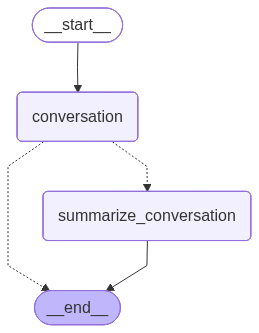

In [7]:

from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:

# Create a thread
config = {"configurable": {"thread_id": "cooking_thread"}}

# Start conversation
input_message = HumanMessage(content="Hello! I'm Alex. I want to cook something delicious tonight.")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="What are some easy dinner ideas for someone who loves Italian food?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="I have pasta, tomatoes, and basil. What can I make with these?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="Tell me the steps for making a simple pasta with tomato and basil sauce.")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="Should I add garlic or onions?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="What kind of pasta works best?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="Great, I'll try making spaghetti with this. Thanks!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hey Alex! 👋  
Sounds like a delicious evening is on the horizon. Let’s make sure we pick something that fits your taste, time, and pantry.

### Quick Questions
1. **Dietary preferences / restrictions?** (e.g., vegetarian, gluten‑free, keto, no dairy, etc.)  
2. **What ingredients do you already have on hand?** (Feel free to list a few key items.)  
3. **How much time do you want to spend cooking?** (e.g., 15 min, 30 min, 1 hr)  
4. **What’s your comfort level in the kitchen?** (Beginner, intermediate, advanced)  
5. **Any particular cuisine or flavor profile you’re craving?** (Italian, Mexican, comfort food, something spicy, etc.)

Once I have a bit more info, I’ll suggest a recipe that’s tasty, doable, and tailored to your situation. If you’re in a rush, I can also give you a “quick‑fire” option. Let me know!
================================== Ai Message ==================================

Here are **six

In [9]:

config = {"configurable": {"thread_id": "cooking_thread"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="Great, I'll try making spaghetti with this. Thanks!", additional_kwargs={}, response_metadata={}, id='b6bd65d5-9f4f-454a-859b-5e6195ae4e7f'), AIMessage(content='Sounds delicious! 🍝✨\n\nIf you run into any questions while cooking—whether it’s timing, seasoning tweaks, or a quick garnish idea—just let me know. Happy cooking!', additional_kwargs={'reasoning_content': "User says they'll try making spaghetti with this. They thanked. We should respond politely, maybe offer encouragement, maybe ask if they need anything else."}, response_metadata={'token_usage': {'completion_tokens': 77, 'prompt_tokens': 2365, 'total_tokens': 2442, 'completion_time': 0.075217872, 'prompt_time': 0.126138046, 'queue_time': 0.050599604, 'total_time': 0.201355918}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_c5a89987dc', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--1de9e3a1-

In [10]:

config = {"configurable": {"thread_id": "cooking_thread"}}
graph_state = graph.get_state(config)
graph_state


StateSnapshot(values={'messages': [HumanMessage(content="Great, I'll try making spaghetti with this. Thanks!", additional_kwargs={}, response_metadata={}, id='b6bd65d5-9f4f-454a-859b-5e6195ae4e7f'), AIMessage(content='Sounds delicious! 🍝✨\n\nIf you run into any questions while cooking—whether it’s timing, seasoning tweaks, or a quick garnish idea—just let me know. Happy cooking!', additional_kwargs={'reasoning_content': "User says they'll try making spaghetti with this. They thanked. We should respond politely, maybe offer encouragement, maybe ask if they need anything else."}, response_metadata={'token_usage': {'completion_tokens': 77, 'prompt_tokens': 2365, 'total_tokens': 2442, 'completion_time': 0.075217872, 'prompt_time': 0.126138046, 'queue_time': 0.050599604, 'total_time': 0.201355918}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_c5a89987dc', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--1de9e3a1-